In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Data Overview

In [2]:
# Read the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# We also have raw train and test data
raw_train_data = pd.read_csv('train_raw.csv')
raw_test_data = pd.read_csv('test_raw.csv')

In [3]:
# Look at the raw data
raw_train_data.head()

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED
0,ID_VBWWP,Uasin Gishu,Sub-county Hospitals and Nursing Homes,18.0,I am a nurse with 18 years of experience in Ge...,Pediatric Emergency Burns,SURGERY,Summary:\nA 4 year old with 5% superficial bur...,Given your vast experience as a nurse in Uasin...,1. Immediate treatment protocol for second-deg...,Here's a response addressing the questions reg...,288514009 | Burn involving 5 percent of body s...
1,ID_XMBBY,Uasin Gishu,National Referral Hospitals,17.0,I am a nurse with 17 years of experience in Ge...,Child Health,PAEDIATRICS,Summary\n6-year-old present with vomiting and ...,Clinical Summary: • A 6-year-old girl w...,Based on the symptoms and signs you've describ...,"Based on the presentation, the 6-year-old girl...",420270002 | Ketoacidosis due to type 1 diabete...
2,ID_JZNZW,Kiambu,Sub-county Hospitals and Nursing Homes,12.0,I am a nurse with 12 years of experience in Ge...,General Emergency,INTERNAL MEDICINE,Summary\nA 47-year-old man presents with sever...,"In this case, you're dealing with a 47-year-ol...","Firstly, I must commend you on your thorough h...","This 47-year-old male presenting with severe, ...",13200003 | Peptic ulcer (disorder)\n25458004 |...
3,ID_QOQTK,Uasin Gishu,National Referral Hospitals,12.0,I am a nurse with 12 years of experience in Pr...,Critical Care,INTERNAL MEDICINE,SUMMARY\n\n72-year-old female with inability t...,"Given ER's clinical presentation and vitals, t...",to me with this query. Based on the informatio...,This 92-year-old female patient (ER) presents ...,14760008 | Constipation (finding)\n419284004 |...
4,ID_ZFJBM,Uasin Gishu,National Referral Hospitals,16.0,I am a nurse with 16 years of experience in Ge...,Adult Health,INTERNAL MEDICINE,"A 22 year old female presents with headache, d...",The 22-year-old female patient is presenting w...,Thank you for presenting this case. Based on t...,This 22-year-old female patient presents with ...,95874006 | Carbon monoxide poisoning from fire...


In [4]:
train_data.head()

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,summary a 4 year old with 5 superficial burns ...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,288514009 burn involving 5 percent of body sur...
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,summary 6 year old present with vomiting and a...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,420270002 ketoacidosis due to type 1 diabetes ...
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,summary a 47 year old man presents with severe...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,13200003 peptic ulcer disorder 25458004 acute ...
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,summary 72 year old female with inability to w...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,14760008 constipation finding 419284004 altere...
4,ID_ZFJBM,uasin gishu,national referral hospitals,16.0,i am a nurse with 16 years of experience in ge...,adult health,internal medicine,a 22 year old female presents with headache di...,the 22 year old female patient is presenting w...,thank you for presenting this case based on th...,this 22 year old female patient presents with ...,95874006 carbon monoxide poisoning from fire d...


In [5]:
import re
from collections import Counter

def analyze_clinical_content(df, text_column):
    """Extract medical insights from clinical text data"""
    
    # Count demographics
    demographics = {
        'pediatric': 0,
        'adult': 0,
        'geriatric': 0,
        'male': 0,
        'female': 0
    }
    
    # Common medical symptoms/conditions to track
    medical_terms = [
        'fever', 'pain', 'cough', 'headache', 'diabetes', 
        'hypertension', 'bleeding', 'infection', 'trauma',
        'respiratory', 'cardiac', 'neurological'
    ]
    term_counter = Counter()
    
    # Analyze each text
    for text in df[text_column]:
        text = text.lower()
        
        # Check demographics
        if re.search(r'\b(infant|child|\d+[\s-]*(month|year)[-\s]*old.*?(child|girl|boy|infant|baby))', text):
            demographics['pediatric'] += 1
        elif re.search(r'\b\d+[\s-]*(year)[-\s]*old.*?(man|woman|male|female)', text) and not re.search(r'\b(6[5-9]|[7-9]\d|\d{3,})[\s-]*(year)[-\s]*old', text):
            demographics['adult'] += 1
        elif re.search(r'\b(6[5-9]|[7-9]\d|\d{3,})[\s-]*(year)[-\s]*old', text):
            demographics['geriatric'] += 1
            
        if re.search(r'\b(male|man|boy|he|his)\b', text):
            demographics['male'] += 1
        if re.search(r'\b(female|woman|girl|she|her)\b', text):
            demographics['female'] += 1
            
        # Count medical terms
        for term in medical_terms:
            if re.search(fr'\b{term}\w*\b', text):
                term_counter[term] += 1
    
    return {
        'demographics': demographics,
        'medical_terms': term_counter
    }

# Apply to raw train data (modify column name as needed)
if 'Prompt' in raw_train_data.columns:
    clinical_insights = analyze_clinical_content(raw_train_data, 'Prompt')
    print("\nClinical Content Analysis:")
    print(f"Demographics: {clinical_insights['demographics']}")
    print(f"Common medical terms: {dict(clinical_insights['medical_terms'].most_common(5))}")


Clinical Content Analysis:
Demographics: {'pediatric': 99, 'adult': 97, 'geriatric': 15, 'male': 154, 'female': 194}
Common medical terms: {'pain': 133, 'headache': 39, 'bleeding': 37, 'fever': 32, 'cough': 31}


# Data Wrangling

In [6]:
print("\nData Overview:")
print(f"Our training data has {train_data.shape[0]} rows and {train_data.shape[1]} columns.")
print(f"Our test data has {test_data.shape[0]} rows and {test_data.shape[1]} columns.")
print(f"Our raw training data has {raw_train_data.shape[0]} rows and {raw_train_data.shape[1]} columns.")
print(f"Our raw test data has {raw_test_data.shape[0]} rows and {raw_test_data.shape[1]} columns.")


Data Overview:
Our training data has 400 rows and 12 columns.
Our test data has 100 rows and 7 columns.
Our raw training data has 400 rows and 12 columns.
Our raw test data has 100 rows and 7 columns.


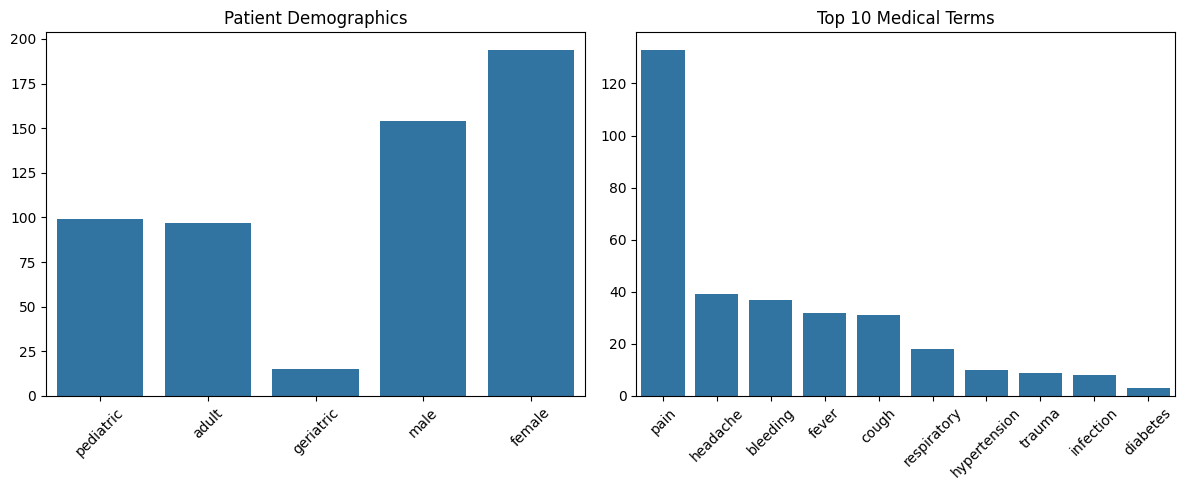


Common Co-occurring Medical Terms:
bleeding + pain: 17 cases
headache + pain: 16 cases
fever + pain: 11 cases
cough + fever: 9 cases
fever + headache: 8 cases

Comparing Raw vs. Processed Data:
Raw training data shape: (400, 12)
Processed training data shape: (400, 12)

Raw data columns: ['Master_Index', 'County', 'Health level', 'Years of Experience', 'Prompt', 'Nursing Competency', 'Clinical Panel', 'Clinician', 'GPT4.0', 'LLAMA', 'GEMINI', 'DDX SNOMED']
Processed data columns: ['Master_Index', 'County', 'Health level', 'Years of Experience', 'Prompt', 'Nursing Competency', 'Clinical Panel', 'Clinician', 'GPT4.0', 'LLAMA', 'GEMINI', 'DDX SNOMED']

Common Medications Mentioned:
{'antibiotic': 13, 'paracetamol': 6, 'insulin': 5, 'analgesic': 4, 'metformin': 2}


In [7]:
# 1. Visualize the demographics and medical terms
import matplotlib.pyplot as plt
import seaborn as sns

# Plot demographics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(clinical_insights['demographics'].keys()), 
            y=list(clinical_insights['demographics'].values()))
plt.title('Patient Demographics')
plt.xticks(rotation=45)

# Plot top medical terms
plt.subplot(1, 2, 2)
top_terms = dict(clinical_insights['medical_terms'].most_common(10))
sns.barplot(x=list(top_terms.keys()), y=list(top_terms.values()))
plt.title('Top 10 Medical Terms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Identify co-occurring medical conditions
def find_comorbidities(df, text_column):
    """Find commonly co-occurring medical conditions"""
    comorbidity_pairs = Counter()
    medical_terms = list(clinical_insights['medical_terms'].keys())
    
    for text in df[text_column]:
        text = text.lower()
        # Find all terms present in this text
        present_terms = [term for term in medical_terms 
                        if re.search(fr'\b{term}\w*\b', text)]
        # Generate all pairs of present terms
        for i in range(len(present_terms)):
            for j in range(i+1, len(present_terms)):
                pair = tuple(sorted([present_terms[i], present_terms[j]]))
                comorbidity_pairs[pair] += 1
                
    return comorbidity_pairs

# Find common comorbidities
comorbidities = find_comorbidities(raw_train_data, 'Prompt')
print("\nCommon Co-occurring Medical Terms:")
for (term1, term2), count in comorbidities.most_common(5):
    print(f"{term1} + {term2}: {count} cases")

# 3. Compare raw data with processed data
print("\nComparing Raw vs. Processed Data:")
print(f"Raw training data shape: {raw_train_data.shape}")
print(f"Processed training data shape: {train_data.shape}")

# Show columns in each dataset
print("\nRaw data columns:", raw_train_data.columns.tolist())
print("Processed data columns:", train_data.columns.tolist())

# 4. Extract medication information
def extract_medications(df, text_column):
    """Extract medication mentions from clinical text"""
    common_meds = [
        'paracetamol', 'ibuprofen', 'aspirin', 'amoxicillin',
        'metformin', 'insulin', 'enalapril', 'amlodipine', 
        'antibiotic', 'analgesic', 'steroid'
    ]
    med_counter = Counter()
    
    for text in df[text_column]:
        text = text.lower()
        for med in common_meds:
            if re.search(fr'\b{med}\w*\b', text):
                med_counter[med] += 1
                
    return med_counter

medications = extract_medications(raw_train_data, 'Prompt')
print("\nCommon Medications Mentioned:")
print(dict(medications.most_common(5)))


Missing Values in Raw Training Data:
Years of Experience    100
DDX SNOMED               1
dtype: int64


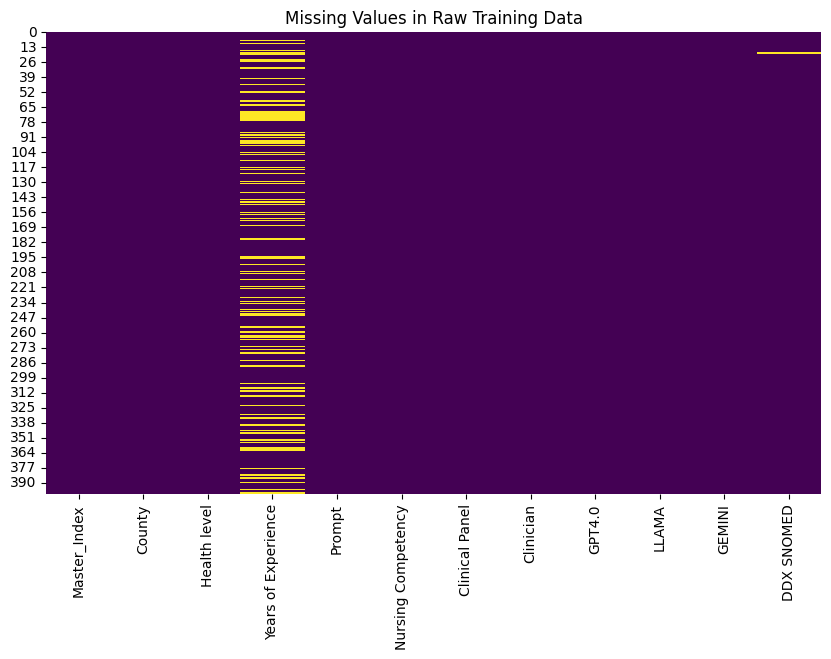


Missing Values in Processed Training Data:
Years of Experience    100
DDX SNOMED               1
dtype: int64


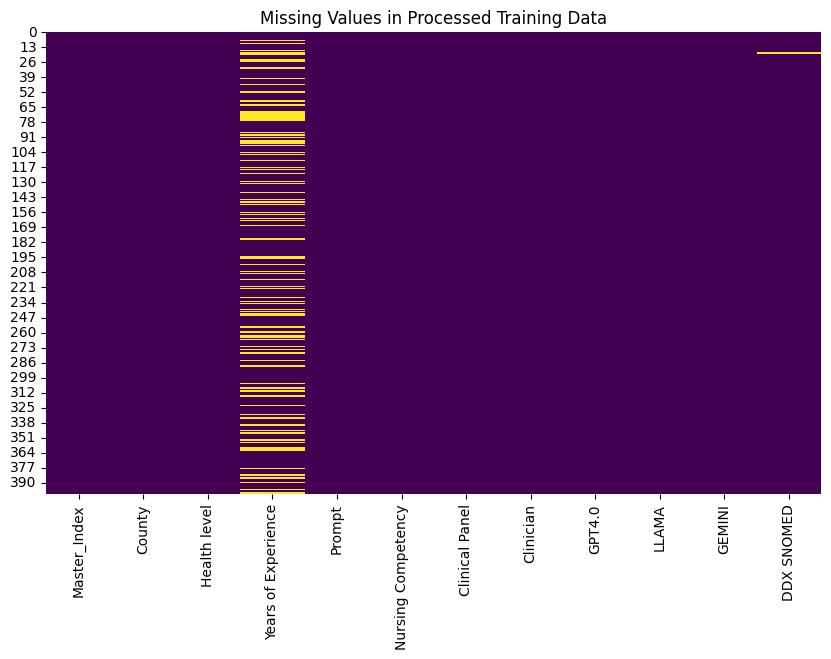

In [8]:
# Check for missing values in the raw data
missing_values = raw_train_data.isnull().sum()
print("\nMissing Values in Raw Training Data:")
print(missing_values[missing_values > 0])
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(raw_train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Raw Training Data')
plt.show()


# Check for missing values in the processed data
missing_values_processed = train_data.isnull().sum()
print("\nMissing Values in Processed Training Data:")
print(missing_values_processed[missing_values_processed > 0])
# Visualize missing values in processed data
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Processed Training Data')
plt.show()

## Feature Engineering

In [9]:
# 5. Create and integrate clinical features
def create_clinical_features(raw_df, include_demographics=True, include_medical=True, 
                           include_medications=True):
    """Create features from raw clinical data for model training"""
    if 'Prompt' not in raw_df.columns:
        return None
        
    features = pd.DataFrame(index=raw_df.index)
    
    # Text length features
    features['prompt_length'] = raw_df['Prompt'].apply(lambda x: len(str(x)))
    
    if include_demographics:
        # Demographic features
        features['is_pediatric'] = raw_df['Prompt'].str.contains(
            r'\b(infant|child|\d+[\s-]*(month|year)[-\s]*old.*?(child|girl|boy|infant|baby))', 
            case=False, regex=True).astype(int)
        features['is_adult'] = raw_df['Prompt'].str.contains(
            r'\b\d+[\s-]*(year)[-\s]*old.*?(man|woman|male|female)', 
            case=False, regex=True).astype(int)
        features['is_geriatric'] = raw_df['Prompt'].str.contains(
            r'\b(6[5-9]|[7-9]\d|\d{3,})[\s-]*(year)[-\s]*old', 
            case=False, regex=True).astype(int)
        features['is_male'] = raw_df['Prompt'].str.contains(
            r'\b(male|man|boy|he|his)\b', 
            case=False, regex=True).astype(int)
        features['is_female'] = raw_df['Prompt'].str.contains(
            r'\b(female|woman|girl|she|her)\b', 
            case=False, regex=True).astype(int)
    
    if include_medical:
        # Medical condition features
        for term in clinical_insights['medical_terms'].keys():
            features[f'has_{term}'] = raw_df['Prompt'].str.contains(
                fr'\b{term}\w*\b', case=False, regex=True).astype(int)
    
    if include_medications:
        # Medication features
        med_list = ['paracetamol', 'ibuprofen', 'aspirin', 'amoxicillin',
                   'metformin', 'insulin', 'antibiotic', 'analgesic', 'steroid']
        for med in med_list:
            features[f'med_{med}'] = raw_df['Prompt'].str.contains(
                fr'\b{med}\w*\b', case=False, regex=True).astype(int)
    
    # Clinical reasoning pattern features
    reasoning_patterns = {
        'differential_diagnosis': r'\b(differential|diagnosis|ddx)\b',
        'lab_tests': r'\b(lab|test|investigation)\w*\b',
        'treatment_plan': r'\b(treat|therapy|medication|management)\w*\b',
        'follow_up': r'\b(follow|review|monitor)\w*\b'
    }
    
    for pattern_name, regex in reasoning_patterns.items():
        features[f'pattern_{pattern_name}'] = raw_df['Prompt'].str.contains(
            regex, case=False, regex=True).astype(int)
    
    return features

# Create features for train and test data
train_clinical_features = create_clinical_features(raw_train_data)
test_clinical_features = create_clinical_features(raw_test_data)

# Display the first few rows of features
print("\nClinical Features Created (First 5 rows):")
print(train_clinical_features.head())
print(f"Total features created: {train_clinical_features.shape[1]}")

# 6. Combine with original training data
# First check what columns exist in the original data
print("\nOriginal training data columns:")
print(train_data.columns.tolist())

# Merge features with training data
train_data = pd.concat([train_data, train_clinical_features], axis=1)
test_data = pd.concat([test_data, test_clinical_features], axis=1)

print("\nEnhanced training data shape:", train_data.shape)
print("Enhanced test data shape:", test_data.shape)


Clinical Features Created (First 5 rows):
   prompt_length  is_pediatric  is_adult  is_geriatric  is_male  is_female  \
0            910             1         0             0        0          0   
1            726             1         0             0        0          1   
2            704             0         0             0        1          0   
3            492             0         0             0        0          1   
4            623             0         1             0        0          1   

   has_pain  has_headache  has_bleeding  has_fever  ...  med_amoxicillin  \
0         1             0             0          0  ...                0   
1         1             0             0          0  ...                0   
2         1             0             0          0  ...                0   
3         1             0             0          0  ...                0   
4         0             1             0          0  ...                0   

   med_metformin  med_insulin  

In [10]:
def extract_clinical_summaries(df, column='Clinician'):
    """Extract clinical summaries often found at start of clinician notes"""
    if column not in df.columns:
        return None
        
    features = pd.DataFrame(index=df.index)
    
    # Check if entry starts with a summary
    def extract_summary(text):
        if not isinstance(text, str):
            return None
        
        # Check for explicit summary sections
        summary_match = re.search(r'^(?:SUMMARY|Summary):\s*(.*?)(?:\n|$)', text)
        if summary_match:
            return summary_match.group(1)
        
        # Check for initial capitalized section that might be a summary
        first_lines = text.split('\n')[0]
        if first_lines.isupper() or first_lines.endswith(':'):
            return first_lines
            
        return None
    
    # Extract summaries
    features['has_summary'] = df[column].apply(lambda x: 1 if extract_summary(x) is not None else 0)
    features['summary_length'] = df[column].apply(lambda x: len(extract_summary(x) or ''))
    
    # Extract clean clinician text (without summary) - ADD TO FEATURES
    features['clinician_clean'] = df[column].apply(
        lambda x: re.sub(r'^(?:SUMMARY|Summary):\s*.*?(?:\n|$)', '', x) if isinstance(x, str) else x
    )
    
    return features

# After combining all features
if 'clinician_clean' in train_data.columns and 'Clinician' in train_data.columns:
    # Replace the original column with the cleaned version
    train_data['Clinician'] = train_data['clinician_clean']
    train_data.drop('clinician_clean', axis=1, inplace=True)
    
    # Do the same for test data if applicable
    if 'clinician_clean' in test_data.columns and 'Clinician' in test_data.columns:
        test_data['Clinician'] = test_data['clinician_clean']
        test_data.drop('clinician_clean', axis=1, inplace=True)

In [11]:
# Enhanced medical entity extraction
def extract_clinical_entities(df, text_column='Prompt'):
    """Extract more sophisticated clinical entities using patterns and keywords"""
    features = pd.DataFrame(index=df.index)
    
    # Vital signs extraction
    vitals_patterns = {
        'temperature': r'(?:temp(?:erature)?|t)\s*(?:of|is|:)?\s*(\d+\.?\d*)\s*(?:c|celsius|f|fahrenheit|°[cf])',
        'blood_pressure': r'(?:bp|blood pressure)\s*(?:of|is|:)?\s*(\d+\/\d+)',
        'heart_rate': r'(?:hr|heart rate|pulse)\s*(?:of|is|:)?\s*(\d+)',
        'respiratory_rate': r'(?:rr|resp(?:iratory)? rate)\s*(?:of|is|:)?\s*(\d+)',
        'oxygen_saturation': r'(?:o2 sat(?:uration)?|spo2)\s*(?:of|is|:)?\s*(\d+)'
    }
    
    for vital, pattern in vitals_patterns.items():
        # Check if vitals are present (1 or 0)
        features[f'has_{vital}'] = df[text_column].str.contains(pattern, case=False, regex=True).astype(int)
    
    # Medical specialties mentioned
    specialties = ['cardiology', 'neurology', 'pediatrics', 'obstetrics', 'gynecology', 
                 'orthopedics', 'dermatology', 'ophthalmology', 'psychiatry', 'oncology']
    
    for specialty in specialties:
        features[f'specialty_{specialty}'] = df[text_column].str.contains(
            fr'\b{specialty}\b', case=False, regex=True).astype(int)
    
    # Disease progression indicators
    progression_terms = {
        'acute': r'\b(?:acute|sudden|rapid)\b',
        'chronic': r'\b(?:chronic|long-term|ongoing|persistent)\b',
        'improving': r'\b(?:improving|better|resolved|resolving)\b',
        'worsening': r'\b(?:worsen|deteriorat|worse|aggravat)\w*\b',
        'recurrent': r'\b(?:recurrent|recurring|repeated|again)\b'
    }
    
    for term, pattern in progression_terms.items():
        features[f'progression_{term}'] = df[text_column].str.contains(pattern, case=False, regex=True).astype(int)
    
    # Clinical procedures mentioned
    procedures = {
        'surgery': r'\b(?:surg(?:ery|ical)|operat(?:ion|ed)|procedure)\b',
        'imaging': r'\b(?:x-?ray|ct|mri|ultrasound|imaging|scan)\b',
        'lab_test': r'\b(?:lab(?:oratory)?|blood|test|culture|biopsy)\b',
        'medication': r'\b(?:medicat|drug|prescri|administ|dose|tablet|pill)\w*\b',
        'referral': r'\b(?:refer|consult|specialist|opinion)\w*\b'
    }
    
    for proc, pattern in procedures.items():
        features[f'procedure_{proc}'] = df[text_column].str.contains(pattern, case=False, regex=True).astype(int)
    
    # Medical history indicators
    history_patterns = {
        'family_history': r'\b(?:family|mother|father|sister|brother|parent)\s*(?:hist(?:ory)?|h/o)\b',
        'past_medical_history': r'\b(?:past|previous|pmh|medical)\s*(?:hist(?:ory)?|h/o)\b',
        'social_history': r'\b(?:social|sh)\s*(?:hist(?:ory)?|h/o)\b',
        'smoking': r'\b(?:smok|cigar|tobacco)\w*\b',
        'alcohol': r'\b(?:alcoho|drink|etoh)\w*\b'
    }
    
    for hist, pattern in history_patterns.items():
        features[f'history_{hist}'] = df[text_column].str.contains(pattern, case=False, regex=True).astype(int)
    
    # Extract common Kenyan/African diseases and conditions (important for localized context)
    african_conditions = {
        'malaria': r'\bmalaria\b',
        'tuberculosis': r'\b(?:tuberculosis|tb)\b',
        'hiv': r'\b(?:hiv|aids)\b', 
        'typhoid': r'\btyphoid\b',
        'cholera': r'\bcholera\b',
        'sickle_cell': r'\bsickle\s*cell\b',
        'malnutrition': r'\bmalnutrition\b'
    }
    
    for condition, pattern in african_conditions.items():
        features[f'condition_{condition}'] = df[text_column].str.contains(pattern, case=False, regex=True).astype(int)
    
    return features

# Apply to data
ner_features = extract_clinical_entities(raw_train_data)
test_ner_features = extract_clinical_entities(raw_test_data)
print("\nClinical Entity Features:")
print(ner_features.head())


Clinical Entity Features:
   has_temperature  has_blood_pressure  has_heart_rate  has_respiratory_rate  \
0                0                   0               0                     0   
1                0                   0               1                     0   
2                0                   0               0                     0   
3                0                   0               0                     0   
4                0                   1               1                     0   

   has_oxygen_saturation  specialty_cardiology  specialty_neurology  \
0                      0                     0                    0   
1                      1                     0                    0   
2                      0                     0                    0   
3                      0                     0                    0   
4                      1                     0                    0   

   specialty_pediatrics  specialty_obstetrics  specialty_gynecolo

In [12]:
# Extract features from clinical vignettes
def analyze_clinical_vignettes(df, text_column='Prompt'):
    """Extract features specific to how the clinical vignettes are structured"""
    features = pd.DataFrame(index=df.index)
    
    # Complexity metrics
    features['vignette_length'] = df[text_column].str.len()
    features['sentence_count'] = df[text_column].str.count(r'[.!?]+')
    features['medical_term_density'] = df[text_column].str.count(r'\b(?:diagnos|disease|symptom|sign|treat)\w*\b') / features['sentence_count'].replace(0, 1)
    
    # Case structure features (typical for clinical reasoning cases)
    features['has_chief_complaint'] = df[text_column].str.contains(
        r'\b(?:presents|presenting|complained|chief complaint|came in with)\b', 
        case=False, regex=True).astype(int)
        
    features['has_history'] = df[text_column].str.contains(
        r'\b(?:history of|past medical|previous|ago)\b', 
        case=False, regex=True).astype(int)
        
    features['has_examination'] = df[text_column].str.contains(
        r'\b(?:exam|examination|assess|evaluation|observed|found)\b', 
        case=False, regex=True).astype(int)
        
    features['has_test_results'] = df[text_column].str.contains(
        r'\b(?:test|lab|result|level|count|rate|investigation showed)\b', 
        case=False, regex=True).astype(int)
    
    # Question types in vignettes (what is being asked)
    features['asks_diagnosis'] = df[text_column].str.contains(
        r'\b(?:what is the diagnosis|most likely diagnosis|what condition)\b', 
        case=False, regex=True).astype(int)
        
    features['asks_next_step'] = df[text_column].str.contains(
        r'\b(?:what is the next step|what would you do next|appropriate management)\b', 
        case=False, regex=True).astype(int)
        
    features['asks_treatment'] = df[text_column].str.contains(
        r'\b(?:how would you treat|appropriate treatment|management plan)\b', 
        case=False, regex=True).astype(int)
    
    return features

# Apply to data
vignette_features = analyze_clinical_vignettes(raw_train_data)
test_vignette_features = analyze_clinical_vignettes(raw_test_data)
print("\nVignette Structure Features:")
print(vignette_features.head())


Vignette Structure Features:
   vignette_length  sentence_count  medical_term_density  has_chief_complaint  \
0              910              14              0.071429                    1   
1              726              10              0.100000                    0   
2              704              10              0.000000                    0   
3              492               8              0.125000                    0   
4              623              10              0.100000                    0   

   has_history  has_examination  has_test_results  asks_diagnosis  \
0            0                0                 0               0   
1            0                0                 0               1   
2            1                0                 0               0   
3            1                0                 0               1   
4            0                0                 0               0   

   asks_next_step  asks_treatment  
0               0               

In [13]:
# Combine all new feature sets
def combine_all_clinical_features(df_train, df_test, raw_train, raw_test):
    """Combine all the extracted clinical features"""
    
    # Create all feature sets for training data
    train_features = [
        ner_features,
        vignette_features
    ]
    
    # Create all feature sets for test data
    test_features = [
        test_ner_features,
        test_vignette_features
    ]
    
    # Add summary features if they exist
    if 'Clinician' in raw_train.columns:
        summary_features = extract_clinical_summaries(raw_train, 'Clinician')
        test_summary_features = extract_clinical_summaries(raw_test, 'Clinician')
        train_features.append(summary_features)
        test_features.append(test_summary_features)
    
    # Combine all training features
    combined_train = pd.concat(
        [feat for feat in train_features if feat is not None], 
        axis=1
    )
    
    # Combine all test features
    combined_test = pd.concat(
        [feat for feat in test_features if feat is not None], 
        axis=1
    )
    
    # Merge with existing data
    enhanced_train = pd.concat([df_train, combined_train], axis=1)
    enhanced_test = pd.concat([df_test, combined_test], axis=1)
    
    return enhanced_train, enhanced_test

# Combine all features
train_data, test_data = combine_all_clinical_features(
    train_data, test_data, raw_train_data, raw_test_data
)

print("\nFinal Enhanced Training Data Shape:", train_data.shape)
print("Final Enhanced Test Data Shape:", test_data.shape)


Final Enhanced Training Data Shape: (400, 92)
Final Enhanced Test Data Shape: (100, 84)


In [14]:
# Direct fix for the "summary" prefix issue
if 'Clinician' in train_data.columns:
    # Remove the word "summary" at the beginning of each entry
    train_data['Clinician'] = train_data['Clinician'].apply(
        lambda x: re.sub(r'^summary\s+', '', str(x), flags=re.IGNORECASE) if isinstance(x, str) else x
    )
    
    if 'Clinician' in test_data.columns:
        test_data['Clinician'] = test_data['Clinician'].apply(
            lambda x: re.sub(r'^summary\s+', '', str(x), flags=re.IGNORECASE) if isinstance(x, str) else x
        )
        
    print("\nSummary prefix removed from Clinician column")

# Verify the change worked
if 'Clinician' in train_data.columns:
    print("\nFirst few entries in Clinician column after cleaning:")
    for i, text in enumerate(train_data['Clinician'].head(3)):
        print(f"Entry {i+1}: {text[:50]}...")


Summary prefix removed from Clinician column

First few entries in Clinician column after cleaning:
Entry 1: a 4 year old with 5 superficial burns no other inj...
Entry 2: 6 year old present with vomiting and abdominal pai...
Entry 3: a 47 year old man presents with severe persistent ...


In [15]:
# Fix for the numeric codes in DDX SNOMED column
if 'DDX SNOMED' in train_data.columns:
    # Remove numeric codes at the beginning (digits followed by space)
    train_data['DDX SNOMED'] = train_data['DDX SNOMED'].apply(
        lambda x: re.sub(r'^\d+\s+', '', str(x)) if isinstance(x, str) else x
    )
    
    if 'DDX SNOMED' in test_data.columns:
        test_data['DDX SNOMED'] = test_data['DDX SNOMED'].apply(
            lambda x: re.sub(r'^\d+\s+', '', str(x)) if isinstance(x, str) else x
        )
    
    print("Numeric codes removed from DDX SNOMED column")

# Verify the changes worked
if 'Clinician' in train_data.columns and 'DDX SNOMED' in train_data.columns:
    print("\nFirst few entries after cleaning:")
    for i in range(min(3, len(train_data))):
        print(f"Row {i+1}:")
        print(f"  DDX SNOMED: {train_data['DDX SNOMED'].iloc[i][:50]}...")
        print()

Numeric codes removed from DDX SNOMED column

First few entries after cleaning:
Row 1:
  DDX SNOMED: burn involving 5 percent of body surface disorder...

Row 2:
  DDX SNOMED: ketoacidosis due to type 1 diabetes mellitus disor...

Row 3:
  DDX SNOMED: peptic ulcer disorder 25458004 acute gastritis dis...



In [16]:
pd.set_option('display.max_columns', None)  # Show all columns in output
train_data.head()

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED,prompt_length,is_pediatric,is_adult,is_geriatric,is_male,is_female,has_pain,has_headache,has_bleeding,has_fever,has_trauma,has_diabetes,has_respiratory,has_cough,has_infection,has_cardiac,has_hypertension,med_paracetamol,med_ibuprofen,med_aspirin,med_amoxicillin,med_metformin,med_insulin,med_antibiotic,med_analgesic,med_steroid,pattern_differential_diagnosis,pattern_lab_tests,pattern_treatment_plan,pattern_follow_up,has_temperature,has_blood_pressure,has_heart_rate,has_respiratory_rate,has_oxygen_saturation,specialty_cardiology,specialty_neurology,specialty_pediatrics,specialty_obstetrics,specialty_gynecology,specialty_orthopedics,specialty_dermatology,specialty_ophthalmology,specialty_psychiatry,specialty_oncology,progression_acute,progression_chronic,progression_improving,progression_worsening,progression_recurrent,procedure_surgery,procedure_imaging,procedure_lab_test,procedure_medication,procedure_referral,history_family_history,history_past_medical_history,history_social_history,history_smoking,history_alcohol,condition_malaria,condition_tuberculosis,condition_hiv,condition_typhoid,condition_cholera,condition_sickle_cell,condition_malnutrition,vignette_length,sentence_count,medical_term_density,has_chief_complaint,has_history,has_examination,has_test_results,asks_diagnosis,asks_next_step,asks_treatment,has_summary,summary_length,clinician_clean
0,ID_VBWWP,uasin gishu,sub county hospitals and nursing homes,18.0,i am a nurse with 18 years of experience in ge...,pediatric emergency burns,surgery,a 4 year old with 5 superficial burns no other...,given your vast experience as a nurse in uasin...,1 immediate treatment protocol for second degr...,here s a response addressing the questions reg...,burn involving 5 percent of body surface disorder,910,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,910,14,0.071429,1,0,0,0,0,0,0,1,57,\nImmediate Management:\n\n * Paracetamol anal...
1,ID_XMBBY,uasin gishu,national referral hospitals,17.0,i am a nurse with 17 years of experience in ge...,child health,paediatrics,6 year old present with vomiting and abdominal...,clinical summary • a 6 year old girl with know...,based on the symptoms and signs you ve describ...,based on the presentation the 6 year old girl ...,ketoacidosis due to type 1 diabetes mellitus d...,726,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,726,10,0.100000,0,0,0,0,1,0,0,0,0,Summary\n6-year-old present with vomiting and ...
2,ID_JZNZW,kiambu,sub county hospitals and nursing homes,12.0,i am a nurse with 12 years of experience in ge...,general emergency,internal medicine,a 47 year old man presents with severe persist...,in this case you re dealing with a 47 year old...,firstly i must commend you on your thorough hi...,this 47 year old male presenting with severe r...,peptic ulcer disorder 25458004 acute gastritis...,704,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,704,10,0.000000,0,1,0,0,0,0,0,0,0,Summary\nA 47-year-old man presents with sever...
3,ID_QOQTK,uasin gishu,national referral hospitals,12.0,i am a nurse with 12 years of experience in pr...,critical care,internal medicine,72 year old female with inability to walk abdo...,given er s clinical presentation and vitals th...,to me with this query based on the information...,this 92 year old female patient er presents wi...,constipation finding 419284004 altered mental ...,492,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,492,8,0.125000,0,1,0,0,1,0,0,1,7,SUMMARY\n\n72-year-old female with inability t...
4,ID_ZFJBM,uasin gishu,national referral hos


Missing Values in Final Enhanced Training Data:
Years of Experience    100
DDX SNOMED               1
dtype: int64


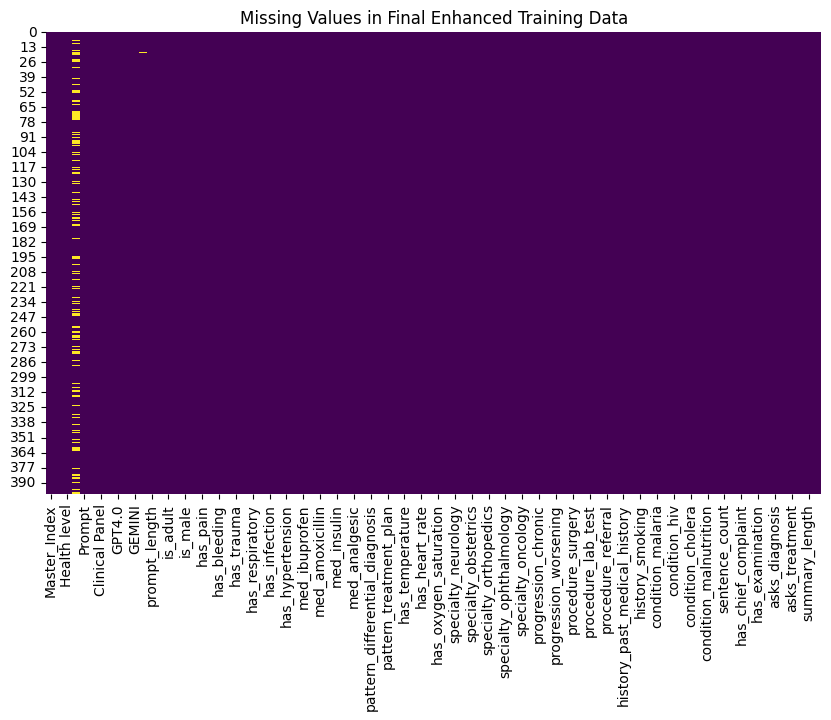

In [17]:
# Check for missing values in the data after all transformations
missing_values_final = train_data.isnull().sum()
print("\nMissing Values in Final Enhanced Training Data:")
print(missing_values_final[missing_values_final > 0])
# Visualize missing values in the final enhanced training data
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Final Enhanced Training Data')
plt.show()

In [18]:
# Imputing missing values
def impute_missing_values(df):
    """Impute missing values in the DataFrame"""
    # Fill numeric columns with mean
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    # Fill categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df
# Impute missing values in both train and test data
train_data = impute_missing_values(train_data)
test_data = impute_missing_values(test_data)

# Verify missing values after imputation
missing_values_after_imputation = train_data.isnull().sum()
print("\nMissing Values After Imputation in Final Enhanced Training Data:")
print(missing_values_after_imputation[missing_values_after_imputation > 0])


Missing Values After Imputation in Final Enhanced Training Data:
Series([], dtype: int64)


# Modeling

In [19]:
# Import necessary libraries for modeling
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq
from sklearn.model_selection import train_test_split
from datasets import Dataset
import evaluate
import numpy as np

In [21]:
# Define model name - choose a medical domain specific model
# model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
model_name = "google/flan-t5-small"  # 80M parameters
# model_name = "facebook/bart-base"    # 140M parameters

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [22]:
# Prepare training data
def prepare_dataset(df, tokenizer, max_input_length=512, max_target_length=512):
    # Create proper format for seq2seq training
    dataset = Dataset.from_pandas(df)
    
    def preprocess_function(examples):
        # Use your enhanced features here
        inputs = examples["Prompt"]
        
        # Optionally, enhance prompts with selected features
        enhanced_inputs = []
        for i, prompt in enumerate(inputs):
            # Extract key clinical features
            features = []
            if examples["is_pediatric"][i] == 1:
                features.append("pediatric case")
            if examples["is_geriatric"][i] == 1:
                features.append("geriatric case")
            
            # Add relevant disease conditions from your feature set
            medical_features = []
            for col in df.columns:
                if col.startswith('has_') and examples[col][i] == 1:
                    medical_features.append(col.replace('has_', ''))
            
            # Create enhanced prompt
            enhanced_input = f"Clinical case with {', '.join(features)}. " \
                            f"Medical conditions: {', '.join(medical_features[:3])}. " \
                            f"Original prompt: {prompt}"
            enhanced_inputs.append(enhanced_input)
        
        model_inputs = tokenizer(enhanced_inputs, max_length=max_input_length, 
                              truncation=True, padding="max_length")
        
        # Tokenize targets
        labels = tokenizer(examples["Clinician"], max_length=max_target_length,
                         truncation=True, padding="max_length")
        
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs
    
    # Apply preprocessing
    tokenized_dataset = dataset.map(
        preprocess_function, 
        batched=True,
        remove_columns=dataset.column_names
    )
    return tokenized_dataset

In [ ]:
# Create train/validation split
train_df, val_df = train_test_split(train_data, test_size=0.1, random_state=42)

# Prepare datasets
train_dataset = prepare_dataset(train_df, tokenizer)
val_dataset = prepare_dataset(val_df, tokenizer)

# Collator for batching
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Load evaluation metric (ROUGE)
rouge = evaluate.load('rouge')

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Compute ROUGE scores
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return result

# Define training arguments optimized for resource constraints
training_args = Seq2SeqTrainingArguments(
    output_dir="./kenya_clinical_model",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    generation_max_length=512,
    report_to="none",  # Disable wandb/tensorboard to save memory
    fp16=True,  # Mixed precision training
    gradient_accumulation_steps=4  # Helps with memory usage
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

Map: 100%|██████████| 40/40 [00:00<00:00, 994.34 examples/s]
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss


In [ ]:
# Model quantization for resource constraints
from transformers import AutoModelForSeq2SeqLM

# Save the model
trainer.save_model("./final_model")

# Load and quantize model for deployment
model_to_quantize = AutoModelForSeq2SeqLM.from_pretrained("./final_model")

# 8-bit quantization
quantized_model = torch.quantization.quantize_dynamic(
    model_to_quantize, {torch.nn.Linear}, dtype=torch.qint8
)

# Save quantized model
torch.save(quantized_model.state_dict(), "./quantized_model.pth")

In [ ]:
def generate_clinical_response(prompt, model, tokenizer, max_length=512):
    # Tokenize input prompt
    inputs = tokenizer(prompt, return_tensors="pt", max_length=max_length, 
                     truncation=True, padding="max_length")
    
    # Generate prediction with constrained decoding parameters
    output_ids = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=3,
        length_penalty=2.0
    )
    
    # Decode output
    prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return prediction

# Test on a sample
sample_prompt = raw_test_data['Prompt'].iloc[0]
response = generate_clinical_response(sample_prompt, model, tokenizer)
print(f"Sample response:\n{response}")

# Generate predictions for test set
test_predictions = []
for prompt in test_data['Prompt']:
    response = generate_clinical_response(prompt, model, tokenizer)
    test_predictions.append(response)

# Create submission file
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Clinician': test_predictions
})

submission.to_csv('submission.csv', index=False)